<a href="https://colab.research.google.com/github/desakim/ESAA_YB2/blob/main/desakim_YB2_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 정확도(Accuracy)

In [1]:
from sklearn.base import BaseEstimator
import numpy as np
class MyDummyClassifier(BaseEstimator):
  # fit() 메서드는 아무것도 학습하지 않음
  def fit(self, X, y = None):
    pass
  # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self, X):
    pred = np.zeros((X.shape[0], 1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i] == 1:
        pred[i] = 0
      else:
        pred[i] = 1
    return pred

In [2]:
# 데이터 가공
# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
  return df

# 레이블 인코딩 수행
from sklearn.preprocessing import LabelEncoder
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size =0.2, random_state=0)

In [3]:
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


정확도를 평가 지표로 사용할 때는 매우 신중해야 함. 특히 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님. \
MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴보자. MNIST는 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, 이를 기반으로 숫자 Digit를 예측하는 데 사용된다. 사이킷런은 load_digits() API를 통해 MNIST 데이터 세트를 제공함. \
원래 MNIST 데이터 세트는 레이블 값이 0부터 9까지 있는 멀티 레이블 분류를 위한 것임. 이것을 레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환해 이진 분류 문제로 바꿔 보자. 

In [4]:
# 불균형한 데이터 세트와 Dummy Classifier를 생성하기
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass

  # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 변환
  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)
  
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


# 02 오차 행렬(Confusion matrix)

In [6]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

# 03 정밀도(Precision)와 재현율(Recall)=민감도(Sensitivity)

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.20, random_state = 11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)                                

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
# 정밀도/재현율 트레이드오프
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


In [10]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값, 분류 결정 임곗값임
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [12]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [13]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋의 값과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
반환된 precisions 배열의 Shape: (166,)
반환된 recalls 배열의 Shape: (166,)
thresholds 5 sample: [0.0116251  0.05292957 0.06229233 0.06365455 0.06864342]
precisions 5 sample: [0.34078212 0.34269663 0.34463277 0.34659091 0.34857143]
recalls 5 sample: [1. 1. 1. 1. 1.]
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


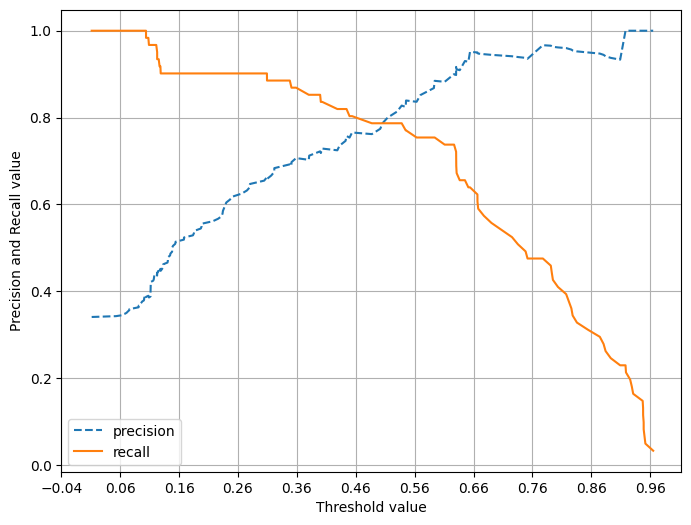

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize = (8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label  ='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

# 04 F1 스코어

In [15]:
from sklearn.metrics import f1_score 

f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [16]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)

    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


# 05 ROC 곡선과 AUC

In [17]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs, tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출. 
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5-step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


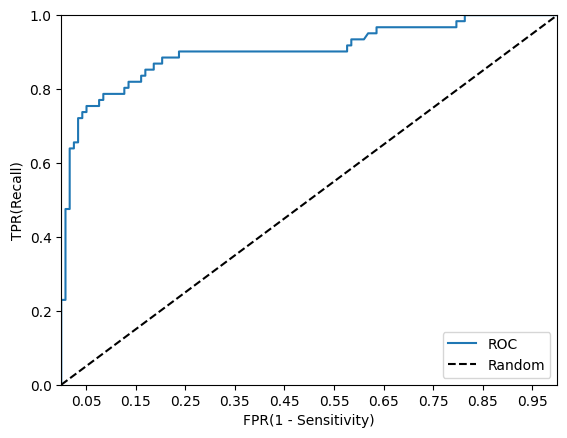

In [18]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환
    fprs, tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림
    plt.plot(fprs, tprs, label = 'ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X,Y 축명 설정 등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [19]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


In [20]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))